# GalleryAI - Immersive Virtual Art Experience
***Building a Multi-Sensory AI Art Guide***

# Table of Contents
1. [Overview 🎯](##overview)
2. [Data Import 📥](##data-import)
3. [Pre-Processing 🧹](##pre-processing)
4. [Exploratory Data Analysis 🔍](##exploratory-data-analysis)
5. [Feature Engineering ⚙️](##feature-engineering)
6. [Model Building & Training 🤖](##model-building--training)
7. [Model Evaluation & Validation 📊](##model-evaluation--validation)
8. [Model Deployment 💾](##model-deployment)
9. [Conclusion & Next Steps 📝](##conclusion--next-steps)


## Overview

**The Art Experience Gap**

> **"Great art should move you, not just inform you."**

While digital art collections have solved the problem of access, they've created a new challenge: emotional connection. Visitors scroll through thousands of artworks without the context, atmosphere, or curation that makes museum visits memorable.

**The Experience Challenge**
- **Emotional Disconnect**: Flat digital representations lack museum ambiance
- **Sensory Poverty**: Visual-only experiences miss music's emotional power
- **Curatorial Void**: Algorithms recommend but don't create meaningful journeys
- **Atmospheric Lack**: No sound, no space, no story

**Solution: GalleryAI**

GalleryAI transforms art discovery from browsing to experience. By combining intelligent recommendations with atmospheric design, we create virtual exhibitions where art and ambiance work together to create emotional connections.

Think of it as:
> **"Part personal curator, part gallery designer, part atmospheric composer"**

**Technical Approach**
- **Content Intelligence**: TF-IDF and Nearest Neighbors for meaningful art connections
- **Multi-Sensory Design**: Integrating visual art with era-appropriate music
- **Experience Architecture**: Designing gallery flows rather than just recommendations
- **Real Data Foundation**: Building on The Met's authentic collection

**Value Proposition**
For **art lovers**: Emotional, immersive art discovery from home
For **educators**: Thematic exhibitions with atmospheric context  
For **designers**: Framework for multi-sensory digital experiences

**Let's build not just a recommendation engine, but an emotional journey through art.**

## Data Import

In [1]:
# Data & ML
import pandas as pd
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import joblib

# API & Images
import requests
import json
from PIL import Image
from io import BytesIO
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading dataset
df = pd.read_csv('/Users/Rosella/Downloads/Personal-Projects/Production-ML-Portafolio/GalleryAI/MetObjects.csv')

# General info
df.info()

# Data columns
print(f'\nRows and columns: {df.shape}')

# First 10 rows
print("\nFirst 10 rows with all columns:")
print(df.head(10).to_string())

# Systematic assesment
missing_analysis = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_analysis / len(df) * 100)

print("\nColumns missing values:")
print(missing_percentage)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484956 entries, 0 to 484955
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Object Number            484956 non-null  object 
 1   Is Highlight             484956 non-null  bool   
 2   Is Timeline Work         484956 non-null  bool   
 3   Is Public Domain         484956 non-null  bool   
 4   Object ID                484956 non-null  int64  
 5   Gallery Number           49541 non-null   object 
 6   Department               484956 non-null  object 
 7   AccessionYear            481094 non-null  object 
 8   Object Name              482690 non-null  object 
 9   Title                    456153 non-null  object 
 10  Culture                  208190 non-null  object 
 11  Period                   91143 non-null   object 
 12  Dynasty                  23201 non-null   object 
 13  Reign                    11236 non-null   object 
 14  Port

The initial exploration reveals several data quality challenges that require systematic addressing:
- **Missing Data**: 59% missing artist names, 43% missing cultural context
- **Type Issues**: Inconsistent date formatting and data types
- **Relevance**: Only 10/45 columns support gallery recommendations
- **Scope**: Need to filter to visually compelling artwork types

**Action Plan**: Column selection → missing value strategy → data type correction → artwork type filtering

## Pre-Processing

In [3]:
# Optimal columns
primary_columns = ['Object ID',
                    'Title', 
                    'Object Name',
                    'Object Begin Date',
                    'Object End Date',
                    'Department', 
                    'Classification',
                    'Medium'
                    ]

image_columns = ['Link Resource',
                  'Dimensions'
                  ]

# Checking missing values percentaje
def checking_nulls(columns):
    for col in columns:
        complete_percentage = (1 - df[col].isnull().mean()) * 100

        print(f'{col}: {complete_percentage}')

checking_nulls(primary_columns)
print()
checking_nulls(image_columns)

# Creating new dataset with select columns
selected_columns = primary_columns + image_columns
data = df[selected_columns].copy()

# Cheking data types for the new dataset
print('\nData Types:')
print(data.dtypes)

# Cheking null values
print('\nNull values before cleaning:')
for col in selected_columns:
    if data[col].isnull().sum() > 0:
        print(f'Column {col}: {data[col].isnull().sum()}')

# Handeling null values
data['Title'].fillna('Untitled', inplace=True)
data['Object Name'].fillna('Artwork', inplace=True)
data['Classification'].fillna('Unclassified', inplace=True)
data['Medium'].fillna('Medium unknown', inplace=True)
data['Dimensions'].fillna('Dimensions unavailable', inplace=True)
print(f'\nNull values after cleaning: {data.isnull().sum().sum()}')

# Checking for duplicates
if data.duplicated().sum() > 0:
    print('⚠️  Duplicates found - investigate before proceeding')
else:
    print('✅ No duplicate records')



Object ID: 100.0
Title: 94.06069829015415
Object Name: 99.53274111465782
Object Begin Date: 100.0
Object End Date: 100.0
Department: 100.0
Classification: 83.76821814762576
Medium: 98.51223616163117

Link Resource: 100.0
Dimensions: 84.5227195869316

Data Types:
Object ID             int64
Title                object
Object Name          object
Object Begin Date     int64
Object End Date       int64
Department           object
Classification       object
Medium               object
Link Resource        object
Dimensions           object
dtype: object

Null values before cleaning:
Column Title: 28803
Column Object Name: 2266
Column Classification: 78717
Column Medium: 7215
Column Dimensions: 75058

Null values after cleaning: 0
✅ No duplicate records


In [4]:
object_name_counts = data['Object Name'].value_counts()
print(f"Unique items in object names: {data['Object Name'].nunique()}")
print("Top 60 object types:")
for obj_name, count in object_name_counts.head(60).items():
    print(f"  {obj_name}: {count} artworks")

classification_count = data['Classification'].value_counts()
print(f"\nUnique items in classification: {data['Classification'].nunique()}")
print("Top 60 Classifications:")
for classification, count in classification_count.head(60).items():
    print(f"  {classification}: {count} artworks")

# Filtering for paintings, sculptures, photographs, drawings
def artwork_filter(data):
    object_mask = data['Object Name'].str.contains('Painting|Sculpture|Photograph|Drawing|Print', na=False, case=False)
    classification_mask = data['Classification'].str.contains('Paintings|Sculpture|Photographs|Drawings|Prints',na=False, case=False)
    art_mask = object_mask | classification_mask

    filtered_data = data[art_mask].copy()
    print(f"Original: {len(data):,} artworks")
    print(f"Filtered: {len(filtered_data):,} artworks")
    
    return filtered_data



# Clean Dataset
print('\n=== CLEAN DATASET ===')
artwork_data = artwork_filter(data).reset_index()
artwork_data.pop('index')
artwork_data.head()

Unique items in object names: 28632
Top 60 object types:
  Print: 102986 artworks
  Photograph: 29451 artworks
  Drawing: 26018 artworks
  Book: 13397 artworks
  Kylix fragment: 8926 artworks
  Piece: 8621 artworks
  Fragment: 7213 artworks
  Painting: 6014 artworks
  Negative: 5928 artworks
  Bowl: 3633 artworks
  Vase: 3219 artworks
  Figure: 3035 artworks
  Dress: 2639 artworks
  Baseball card: 2505 artworks
  Baseball card, print: 2463 artworks
  Textile fragment: 2301 artworks
  Artwork: 2266 artworks
  Plate: 2230 artworks
  Ensemble: 2121 artworks
  Books Prints Ornament & Architecture: 2120 artworks
  Baseball card, photograph: 2099 artworks
  Medal: 1944 artworks
  Dish: 1940 artworks
  Evening dress: 1885 artworks
  Print; ephemera: 1667 artworks
  Panel: 1660 artworks
  Hanging scroll: 1618 artworks
  Carte-de-visite: 1570 artworks
  Hat: 1522 artworks
  Drawing Ornament & Architecture: 1516 artworks
  Print collection ornament & architecture: 1479 artworks
  Ornament: 1464 

,Object ID,Title,Object Name,Object Begin Date,Object End Date,Department,Classification,Medium,Link Resource,Dimensions
0,150,Heads and Feet of Two Javanese Dancers (from S...,Drawing,1889,1889,The American Wing,Unclassified,Graphite on off-white wove paper,http://www.metmuseum.org/art/collection/search...,5 1/2 x 8 1/2 in. (14 x 21.6 cm)
1,194,"Hunting Birds, after Egyptian Relief Sculpture...",Drawing,1875,1878,The American Wing,Unclassified,Graphite and pen and ink on off-white wove paper,http://www.metmuseum.org/art/collection/search...,5 1/4 x 4 3/4 in. (13.3 x 12.1 cm)
2,466,Plaque Portrait of Benjamin Franklin,Painting,1800,1883,The American Wing,Unclassified,Ivory,http://www.metmuseum.org/art/collection/search...,3 1/4 x 2 5/8 in. (8.3 x 6.7 cm)
3,467,Plaque Portrait of Benjamin Franklin,Painting,1776,1883,The American Wing,Unclassified,Enamel,http://www.metmuseum.org/art/collection/search...,2 3/8 x 2 in. (6 x 5.1 cm)
4,468,Plaque Portrait of Benjamin Franklin,Painting,1776,1883,The American Wing,Unclassified,Ivory,http://www.metmuseum.org/art/collection/search...,Diam. 3 3/16 in. (8.1 cm)


Data preprocessing curated a focused collection of 223,238 artworks, preparing 10 core columns for experiential analysis:
* Feature Selection: 10 columns with high completeness (>83%) covering artwork identity, historical context, and visual resources—the essential elements for building narrative exhibitions.
* Data Types: Dates preserved as integers to facilitate era-based storytelling and emotional segmentation (e.g., "Renaissance to Enlightenment").
* Missing Values: Strategic placeholders ("Unknown", "Unclassified") maintain data integrity for categorical columns without disrupting thematic grouping.
* Collection Integrity: A clean, duplicate-free dataset ready to uncover the patterns that drive emotional and thematic art journeys.

Ready for Exploratory Data Analysis to reveal the core artistic mediums, historical concentrations, and categorical relationships that will form the foundation of GalleryAI's immersive experiences.

## Exploratory Data Analysis

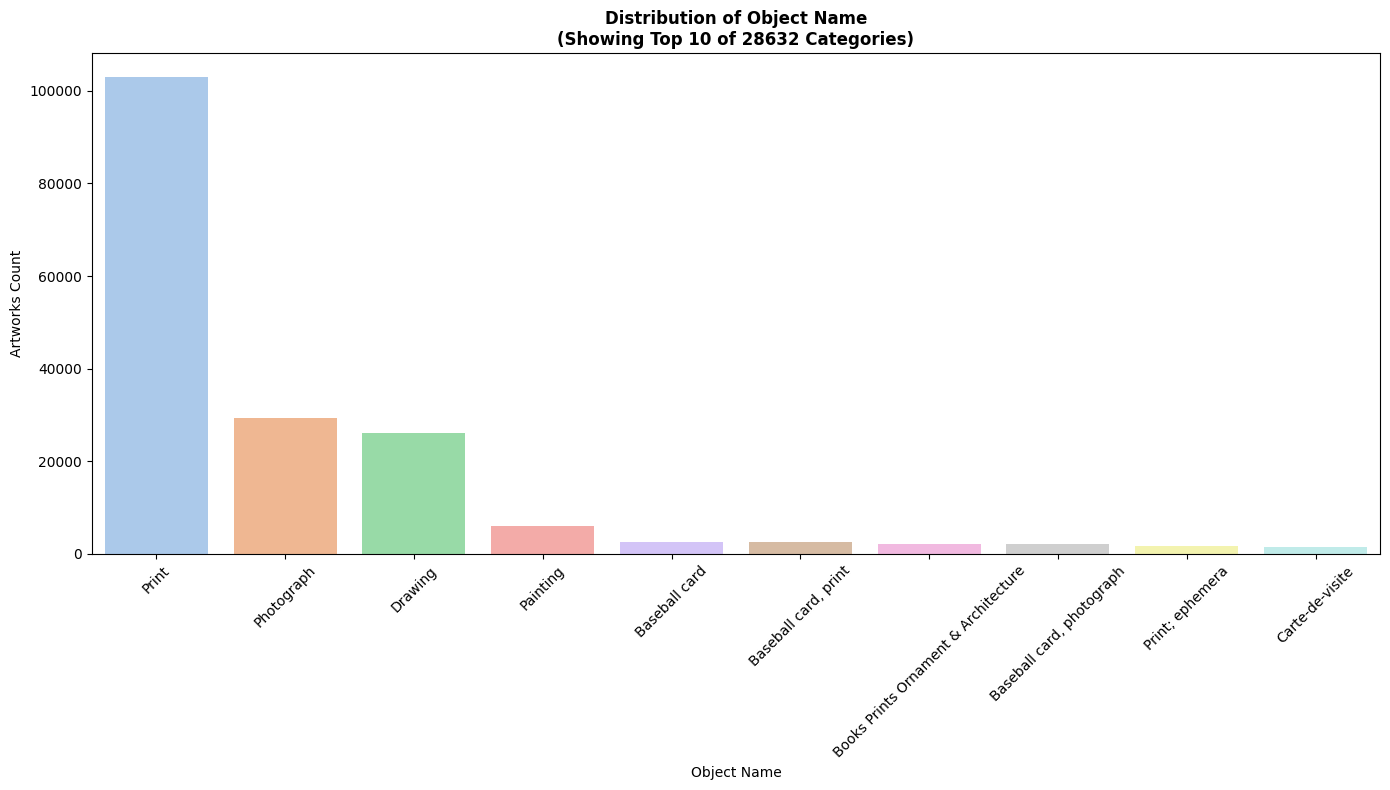

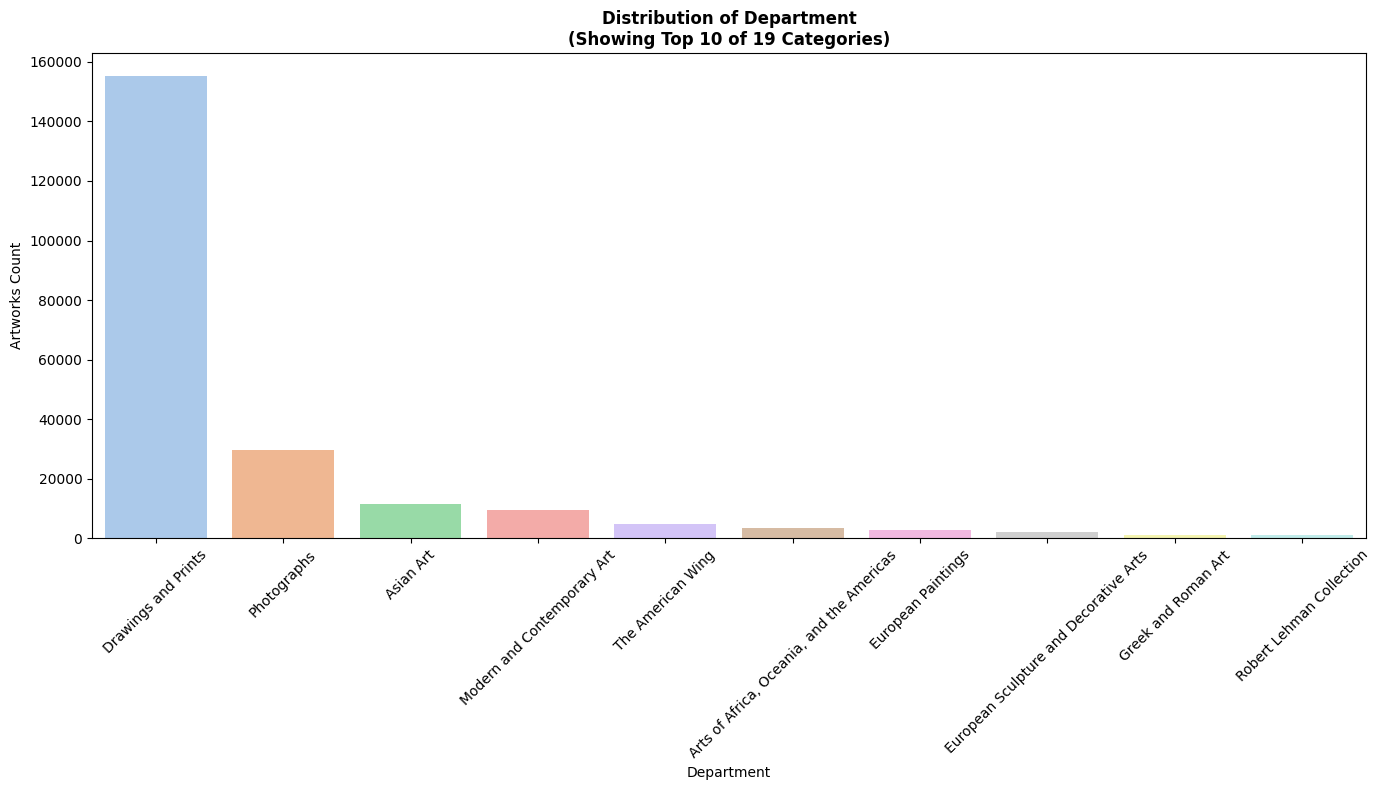

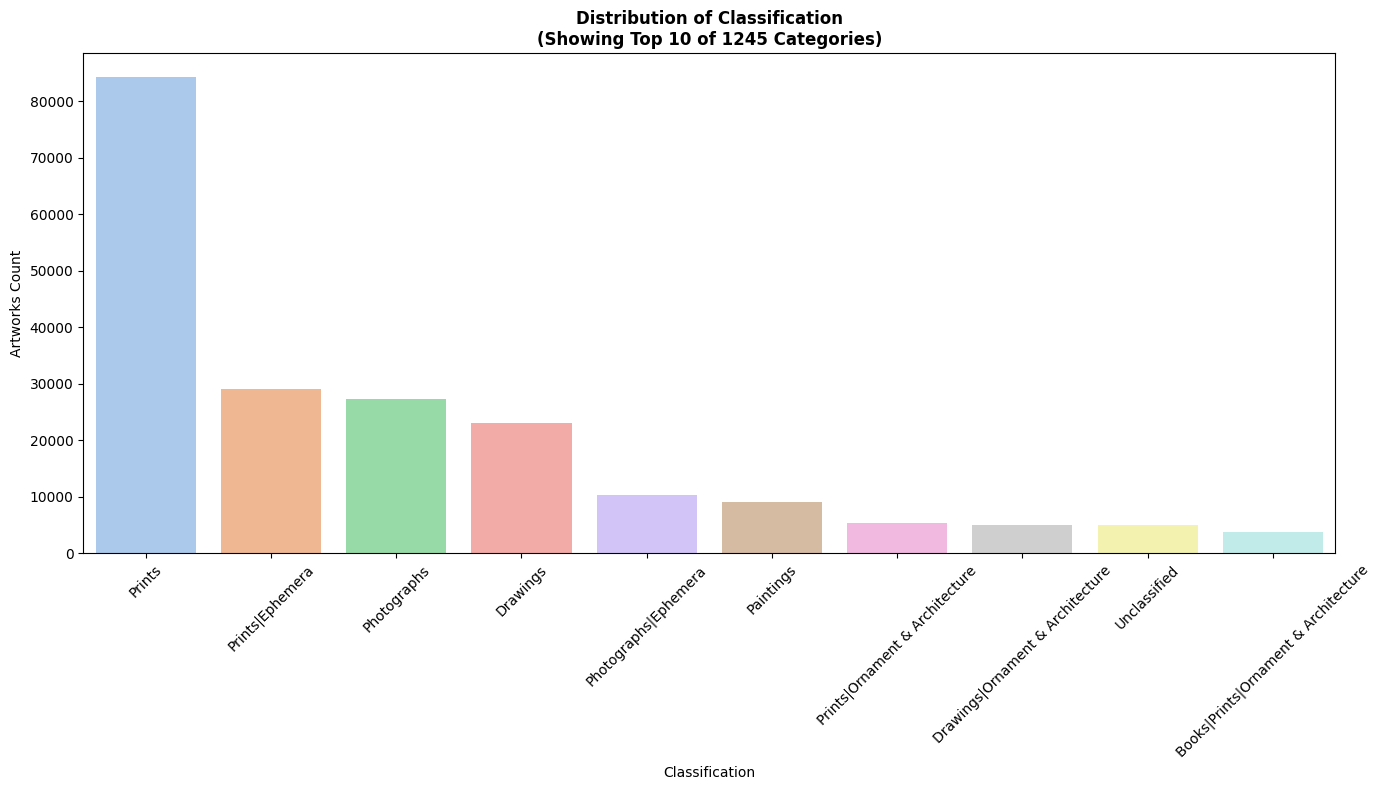

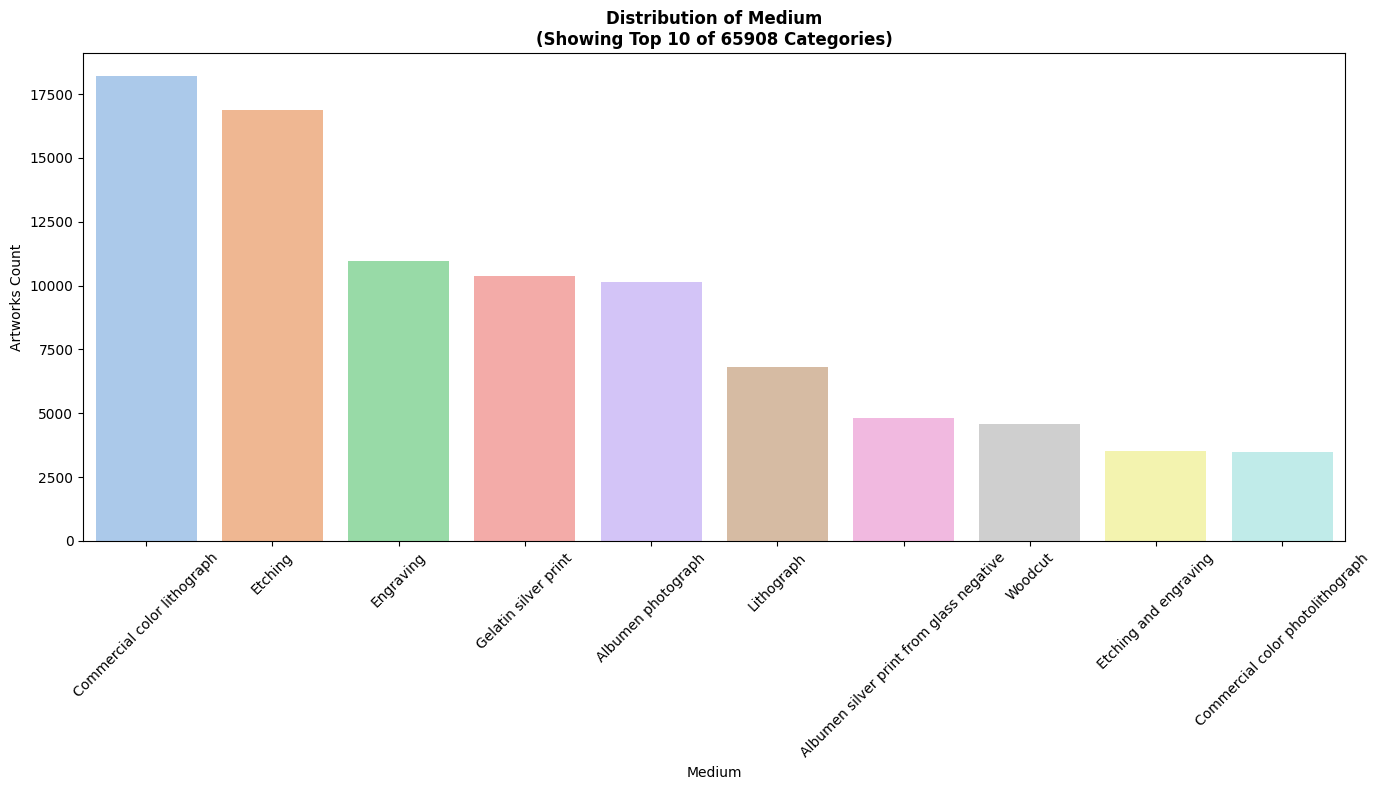

In [29]:
# Categorical columns exploration
categorical_columns = ['Object Name', 'Department', 'Classification', 'Medium']


for col in categorical_columns:
    # Top categories
    cat_value_counts = artwork_data[col].value_counts().head(10)
    plt.figure(figsize=(14, 8))
    bar1 = sns.barplot(x=cat_value_counts.index, y=cat_value_counts.values, palette='pastel')
    plt.title(f'Distribution of {col}\n(Showing Top 10 of {data[col].nunique()} Categories)', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Artworks Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

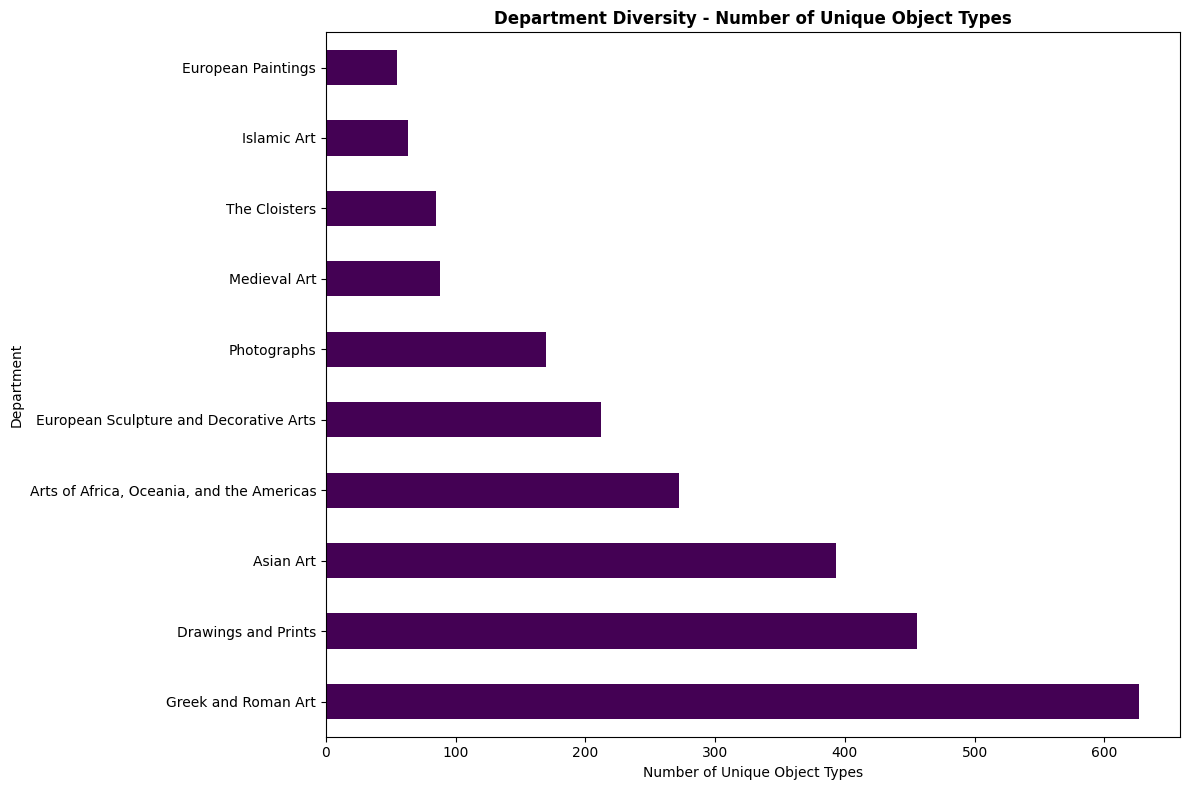

In [30]:
# Deparments with most diverse collections
dept_diversity = artwork_data.groupby('Department')['Object Name'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
dept_diversity.plot(kind='barh', colormap='viridis')
plt.title('Department Diversity - Number of Unique Object Types', fontweight='bold')
plt.xlabel('Number of Unique Object Types')
plt.tight_layout()
plt.show()



== ARTWORK BY HISTORICAL ERA ==
Artwork Era
Renaissance to Enlightenment    69193
19th Centuary                   62103
20th Centuary                   49641
Classical                       20556
Medival                         12172
Ancient - Bronze Age             4807
Ancient - Iron Age               2144
Prehistoric                      1842
Modern/Contemporary               780
Name: count, dtype: int64

=== EVOLUTION OF ARTISTIC MATERIALS OVER TIME ===


<Figure size 1400x1200 with 0 Axes>

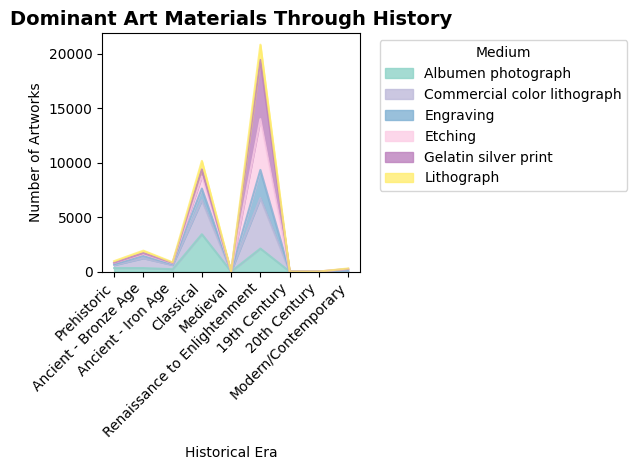

In [5]:
# Artworks by eras
def categorized_by_centuary(begin_date):
    if begin_date < -4000:
        return 'Prehistoric'
    elif -4000 <= begin_date < -1200:
        return 'Ancient - Bronze Age'
    elif -800 <= begin_date < 500:
        return 'Classical'
    elif 500 <= begin_date < 1500:
        return 'Medival'
    elif 1500 <= begin_date < 1800:
        return 'Renaissance to Enlightenment'
    elif 1800 <= begin_date < 1900:
        return '19th Centuary'
    elif 1900 <= begin_date < 2000:
        return '20th Centuary'
    elif begin_date >= 2000:
        return 'Modern/Contemporary'
    else:
        return 'Ancient - Iron Age'

artwork_data['Artwork Era'] = data['Object Begin Date'].apply(categorized_by_centuary)
col = artwork_data.pop('Artwork Era')
artwork_data.insert(5, 'Artwork Era', col)
print('\n== ARTWORK BY HISTORICAL ERA ==') 
print(artwork_data['Artwork Era'].value_counts())

# Evolution of mediums by eras
print("\n=== EVOLUTION OF ARTISTIC MATERIALS OVER TIME ===")
top_6_mediums = artwork_data['Medium'].value_counts().head(6).index
evolution_data = artwork_data[artwork_data['Medium'].isin(top_6_mediums)]

# Create timeline data
timeline = evolution_data.groupby(['Artwork Era', 'Medium']).size().unstack(fill_value=0)
era_order = ['Prehistoric', 'Ancient - Bronze Age', 'Ancient - Iron Age', 'Classical', 'Medieval', 'Renaissance to Enlightenment', '19th Century', '20th Century', 'Modern/Contemporary']
timeline = timeline.reindex(era_order)

plt.figure(figsize=(14, 12))
timeline.plot(kind='area', stacked=True, colormap='Set3', alpha=0.8)
plt.title('Dominant Art Materials Through History', fontweight='bold', fontsize=14)
plt.xlabel('Historical Era')
plt.ylabel('Number of Artworks')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Medium', frameon=True)
plt.xticks(range(len(era_order)), era_order, rotation=45, ha='right') 
plt.tight_layout()
plt.subplots_adjust()
plt.show()

The analysis reveals a collection curated for emotional resonance, with the 19th Century and Renaissance periods offering the deepest pools of historically significant works. The Drawing, Prints, and Photographs departments emerge as the most substantial collections by volume, providing ideal foundations for thematic exhibitions.

Department diversity analysis indicates Greek and Roman Art leads in categorical variety, demonstrating exceptional material breadth for classical storytelling. Drawings and Prints and Asian Art follow with significant diversity, offering rich possibilities for nuanced gallery experiences across different cultural traditions.

Analysis of artistic materials across historical eras shows a distinct emotional progression from traditional printmaking and drawing techniques to modern photographic processes, with albumen prints and gelatin silver prints offering authentic period atmospheres for 19th and 20th-century themed galleries.

These findings form the experience strategy: leverage the extensive photographic and print collections for emotionally accessible exhibitions, utilize the diverse Greek/Roman and Asian art objects for culturally immersive journeys, and strategically surface underrepresented Modern/Contemporary works to provide balanced discovery opportunities that span art historical narratives.

## Feature Engineering

This phase transforms raw categorical data into machine-readable features and establishes the visual component critical for the recommendation experience.

**Visual Content Integration**
A dedicated image extraction pipeline leverages the Met Museum Object API, using each artwork's `Object ID` to retrieve high-quality images via HTTP requests. This ensures the recommendation system displays actual artwork visuals rather than textual descriptions, creating an engaging user experience.

Once objects with available images are identified, the dataset is filtered to include only artworks with confirmed images and selected feature columns. This curated subset ensures both visual integrity and data quality for model training.

**Categorical Feature Engineering**
With the final visual dataset established, categorical columns (`Title`, `Object Name`, `Artwork Era`, `Department`, `Classification`, `Medium`) are processed using TF-IDF vectorization to create semantic feature vectors. This approach captures thematic relationships between artworks based on their descriptive metadata, enabling conten based similarity matching.

In [ ]:
# Visual Content Integration
# Image extraction with error handeling
def get_artwork_images(object_id, max_retries=2):
    for attempt in range(max_retries):
        try:
            url = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{object_id}"
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                primary_image = data.get('primaryImage')
                if primary_image and primary_image.startswith('http'):
                    return {
                        'primaryImage': primary_image,
                        'primaryImageSmall': data.get('primaryImageSmall', ''),
                        'additionalImages': data.get('additionalImages', []),
                        'artist': data.get('artist', 'Unknown')
                    }
                
            elif response.status_code == 404:
                return None
            
        except requests.RequestException as e:
            print(f"Attempt {attempt + 1} failed for object {object_id}: {e}")
            if attempt < max_retries - 1:
                time.sleep(0.5)
    return None

# Testing to make sure images function works
testing_ids = [10, 100, 200, 500, 1000]
print('== TESTING IMAGE EXTRACTION FUNCTION ==')
for id in testing_ids:
    result = get_artwork_images(id)
    status = "Has images" if result else " visual contentNo images"
    print(f"Object ID {id}: {status}")

# Image coverage assessment
print('\n== CHECKING IMAGE AVAILABILITY FOR A SAMPLE ==')
def asses_image_coverage(data, sample_size=500):
    sample = data.sample(min(sample_size, len(data)), random_state=42)
    has_images= 0

    print(f"Assesing image coverage for {len(sample)} artworks...")

    for idx, row in sample.iterrows():
        if get_artwork_images(row['Object ID']):
            has_images += 1
        
        if (idx + 1) % 50 == 0:
            print(f"  Processed {idx + 1}/{len(sample)}...")
        
        time.sleep(0.1)

    coverage = (has_images / len(sample)) * 100
    print(f"Image coverage: {coverage:.1f}% ({has_images}/{len(sample)})")
    return coverage

coverage = asses_image_coverage(artwork_data, sample_size=500)


== TESTING IMAGE EXTRACTION FUNCTION ==
Object ID 10: ❌ No images
Object ID 100: ✅ Has images
Object ID 200: ✅ Has images
Object ID 500: ✅ Has images
Object ID 1000: ✅ Has images

== CHECKING IMAGE AVAILABILITY FOR A SAMPLE ==
Assesing image coverage for 500 artworks...
  Processed 168400/500...
  Processed 42350/500...
  Processed 217350/500...
  Processed 60750/500...
  Processed 219950/500...
  Processed 176700/500...
  Processed 138150/500...
  Processed 200700/500...
  Processed 62750/500...
  Processed 17050/500...
  Processed 41100/500...
📊 Image coverage: 38.4% (192/500)


In [ ]:
# Filtering dataset to keep only the datset wuth artwork images

def build_visual_datset(data, target_min_images=50000):
    visual_artworks = []
    processed = 0

    print(f"Processing {len(data)} artworks for images...")
    print(f"Target: at least {target_min_images} artworks with images")
    
    for idx, row in data.iterrows():
            images = get_artwork_images(row['Object ID'])
            processed += 1

            if images:
                enhanced_row = row.to_dict()
                enhanced_row.update(images)
                visual_artworks.append(enhanced_row)
            
            if processed % 500 == 0:
                print(f"  Progress: {processed:,} processed - Found {len(visual_artworks):,} with images")

            time.sleep(0.12)

            if len(visual_artworks) >= target_min_images:
                print(f"Target reached of {target_min_images:,} artworks with images!")
                break
            
    visual_df = pd.DataFrame(artwork_data)
    print(f"\nFINAL VISUAL DATASET: {len(visual_df):,} artworks with confirmed images")
    return visual_df


full_data = build_visual_datset(artwork_data, target_min_images=50000)


Processing 223238 artworks for images...
Target: at least 50000 artworks with images
  Progress: 500 processed - Found 372 with images


In [ ]:
# Categorical Feature Engineering
# Combine categorical columns in one feature
final_data['Combined Features'] = (
    final_data['Title'] + " | " +
    final_data['Object Name'] + " | " +
    final_data['Artwork Era'] + " | " +
    final_data['Department'] + " | " + 
    final_data['Classification'] + " | " +
    final_data['Medium']
)

# Example of the new combined features
print('== COMBINED FEATURES ==')
print(f'Sample of combined features:\n{final_data['Combined Features'].iloc[0]}')

# Initialize and fit the vectorizer
vectorizer = TfidfVectorizer(
    max_features=30000,
    stop_words='english',
    ngram_range=(1, 2)
)
tfidf_matrix = vectorizer.fit_transform(final_data['Combined Features'])

print("\n=== OPTIMIZED TF-IDF ===")
print(f"Feature matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
